In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import func
import talib
import math
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [2]:
factor_path = "/Users/shezihua/Documents/MAFM/2022-2023 Summer/MAFS 6100L/SummerIndependentProject/factor/"

futureCodeList = ['JBF', 'QWF', 'HCF', 'DBF', 'EHF', 'IPF', 'IIF', 'QXF', 'PEF', 'NAF']
stockCodeList = ['3443', '2388', '2498', '2610', '1319', '3035', '3006', '2615', '5425', '3105']
futureCode = futureCodeList[1]
stockCode = stockCodeList[1]

In [3]:
feature = pd.read_csv(factor_path + futureCode + "-" + stockCode + "/factor.csv.gz", compression='gzip', index_col=0)

In [4]:
corr_table = feature.corr()
corr_table.style.background_gradient(cmap='coolwarm')

,spread,MA_5,MA_20,MA_60,MACD,MACDsignal,MACDhist,RSI,EMA_5,EMA_20,EMA_60,Stock_Ask_Bid_Price_Depth_Ratio,stockprice,midQuote,Stock_Ask_Bid_Total_Volume_Ratio,stock_pressure,delta_pressure,delta_future_askPrice1,delta_future_bidPrice1,delta_stock_SP1,delta_stock_BP1,stock_trade_size,delta_stock_trade_size,vol_5_tick,vol_20_tick,vol_60_tick,delta_spread
spread,1.000000,0.998511,0.995041,0.990104,0.102243,0.096590,0.039095,0.072238,0.999063,0.996470,0.992578,-0.003825,-0.139875,-0.151216,0.008696,0.067265,-0.000038,0.005655,-0.005704,-0.000038,0.000037,0.003783,0.000032,-0.008144,-0.004904,-0.001509,0.027229
MA_5,0.998511,1.000000,0.997127,0.991913,0.096269,0.100274,0.014904,0.055158,0.999884,0.998344,0.994418,-0.003275,-0.140054,-0.151311,0.007173,0.067239,-0.000088,-0.003132,0.003189,-0.000088,0.000088,0.003747,-0.000200,-0.008613,-0.005634,-0.001911,-0.011987
MA_20,0.995041,0.997127,1.000000,0.996035,0.034812,0.058995,-0.048010,0.019276,0.997344,0.999717,0.997848,-0.002644,-0.140405,-0.151478,0.004232,0.066995,-0.000088,-0.003104,0.003155,-0.000088,0.000088,0.003077,-0.000223,-0.005558,-0.006352,-0.002902,-0.010945
MA_60,0.990104,0.991913,0.996035,1.000000,-0.026329,-0.018722,-0.024517,-0.007677,0.992225,0.996366,0.999505,-0.002350,-0.140908,-0.151719,0.000823,0.066899,-0.000029,-0.002301,0.002336,-0.000030,0.000029,0.002774,-0.000132,-0.002058,-0.002960,-0.003475,-0.007444
MACD,0.102243,0.096269,0.034812,-0.026329,1.000000,0.923385,0.432468,0.523028,0.093766,0.044981,-0.005772,-0.007904,0.001012,-0.002794,0.049665,0.005819,-0.000350,0.000289,-0.000210,-0.000349,0.000351,0.008870,-0.000165,-0.050151,-0.014299,0.013588,-0.004812
MACDsignal,0.096590,0.100274,0.058995,-0.018722,0.923385,1.000000,0.053213,0.418405,0.097397,0.061672,0.005146,-0.005004,0.000890,-0.002695,0.044097,0.005077,-0.000630,-0.014187,0.014433,-0.000628,0.000631,0.007372,-0.000482,-0.048618,-0.027595,0.010292,-0.062199
MACDhist,0.039095,0.014904,-0.048010,-0.024517,0.432468,0.053213,1.000000,0.377810,0.015150,-0.027846,-0.027102,-0.008806,0.000543,-0.000937,0.025620,0.003214,0.000569,0.034076,-0.034447,0.000567,-0.000570,0.005759,0.000703,-0.016265,0.027619,0.011174,0.133575
RSI,0.072238,0.055158,0.019276,-0.007677,0.523028,0.418405,0.377810,1.000000,0.056550,0.026103,0.001620,-0.001017,-0.000078,0.009466,0.049161,0.007176,-0.000015,0.003203,-0.003251,-0.000016,0.000015,0.000580,-0.000575,-0.056951,-0.018976,0.008526,0.176621
EMA_5,0.999063,0.999884,0.997344,0.992225,0.093766,0.097397,0.015150,0.056550,1.000000,0.998501,0.994691,-0.003347,-0.140100,-0.151369,0.007318,0.067264,-0.000077,-0.001647,0.001686,-0.000077,0.000077,0.003723,-0.000170,-0.008266,-0.005547,-0.001888,-0.005259
EMA_20,0.996470,0.998344,0.999717,0.996366,0.044981,0.061672,-0.027846,0.026103,0.998501,1.000000,0.998110,-0.002794,-0.140502,-0.151609,0.004683,0.067119,-0.000081,-0.002981,0.003032,-0.000081,0.000081,0.003259,-0.000185,-0.005998,-0.005722,-0.002712,-0.010422


## Linear regression

In [5]:
feature.index = pd.to_datetime(feature.index)
day_list = np.unique(feature.index.date)

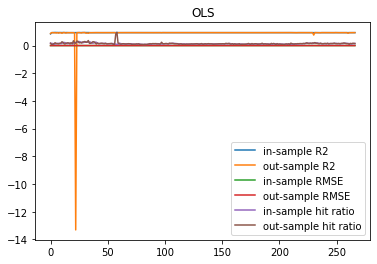

in-sample R2:  0.9338859113962087
out-sample R2:  0.8776156304130813
in-sample RMSE:  0.0001085049742386958
out-sample RMSE:  0.00013150230318660595
in-sample hit ratio:  0.1345642566736557
out-sample hit ratio:  0.14347081443446708


In [12]:
all_r2_in = []
all_r2_out = []
all_rmse_in = []
all_rmse_out = []
all_hit_ratio_in = []
all_hit_ratio_out = []

train_period = 3

for i in range(len(day_list) - train_period):
    train_start_time = feature.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train_end_time = feature.index < pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train = feature[train_start_time & train_end_time]
    test_start_time = feature.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test_end_time = feature.index < pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test = feature[test_start_time & test_end_time]

    X_train = train[train.columns[0:-1]]
    X_test = test[test.columns[0:-1]]
    y_train = train['delta_spread']
    y_test = test['delta_spread']

    model_ols = LinearRegression()
    model_ols.fit(X_train, y_train)

    y_train_pred = model_ols.predict(X_train)
    y_test_pred = model_ols.predict(X_test)

    r2_in = model_ols.score(X_train, y_train)
    r2_out = model_ols.score(X_test, y_test)
    rmse_in = np.sqrt(np.mean((model_ols.predict(X_train) - y_train) ** 2))
    rmse_out = np.sqrt(np.mean((model_ols.predict(X_test) - y_test) ** 2))  

    hit_ratio_in = 0
    hit_ratio_out = 0
    for i in range(len(y_train_pred)):
        if y_train_pred[i] * y_train[i] > 0:
            hit_ratio_in += 1

    for i in range(len(y_test_pred)):
        if y_test_pred[i] * y_test[i] > 0:
            hit_ratio_out += 1

    all_r2_in.append(r2_in)
    all_r2_out.append(r2_out)
    all_rmse_in.append(rmse_in)
    all_rmse_out.append(rmse_out)
    all_hit_ratio_in.append(hit_ratio_in / len(y_train_pred))
    all_hit_ratio_out.append(hit_ratio_out / len(y_test_pred))
    
plt.plot(all_r2_in, label='in-sample R2')
plt.plot(all_r2_out, label='out-sample R2')
plt.plot(all_rmse_in, label='in-sample RMSE')
plt.plot(all_rmse_out, label='out-sample RMSE')
plt.plot(all_hit_ratio_in, label='in-sample hit ratio')
plt.plot(all_hit_ratio_out, label='out-sample hit ratio')
plt.title('OLS')
plt.legend()
plt.show()

print("in-sample R2: ", sum(all_r2_in) / len(all_r2_in))
print("out-sample R2: ", sum(all_r2_out) / len(all_r2_out))
print("in-sample RMSE: ", sum(all_rmse_in) / len(all_rmse_in))
print("out-sample RMSE: ", sum(all_rmse_out) / len(all_rmse_out))
print("in-sample hit ratio: ", sum(all_hit_ratio_in) / len(all_hit_ratio_in))
print("out-sample hit ratio: ", sum(all_hit_ratio_out) / len(all_hit_ratio_out))


## Tree method

In [8]:
i = 0
train_period = 3
train_start_time = feature.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
train_end_time = feature.index < pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
train = feature[train_start_time & train_end_time]
test_start_time = feature.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
test_end_time = feature.index < pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
test = feature[test_start_time & test_end_time]

X_train = train[train.columns[0:-1]]
X_test = test[test.columns[0:-1]]
y_train = train['delta_spread']
y_test = test['delta_spread']

In [9]:
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.datasets import  make_classification

In [13]:
gbm = lgb.LGBMRegressor(objective='regression',num_leaves=31,learning_rate=0.05,n_estimators=20)
gbm.fit(X_train, y_train,eval_set=[(X_test, y_test)],eval_metric='l1',early_stopping_rounds=5)
# 测试机预测
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
# 模型评估
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

[1]	valid_0's l1: 9.96698e-05	valid_0's l2: 7.12239e-08
[2]	valid_0's l1: 9.68509e-05	valid_0's l2: 6.68222e-08
[3]	valid_0's l1: 9.43089e-05	valid_0's l2: 6.3161e-08
[4]	valid_0's l1: 9.16627e-05	valid_0's l2: 5.94538e-08
[5]	valid_0's l1: 8.99144e-05	valid_0's l2: 5.70381e-08
[6]	valid_0's l1: 8.72907e-05	valid_0's l2: 5.37355e-08
[7]	valid_0's l1: 8.49768e-05	valid_0's l2: 5.13319e-08
[8]	valid_0's l1: 8.25865e-05	valid_0's l2: 4.86839e-08
[9]	valid_0's l1: 8.04133e-05	valid_0's l2: 4.67306e-08
[10]	valid_0's l1: 7.83658e-05	valid_0's l2: 4.49718e-08
[11]	valid_0's l1: 7.66554e-05	valid_0's l2: 4.3351e-08
[12]	valid_0's l1: 7.49636e-05	valid_0's l2: 4.18243e-08
[13]	valid_0's l1: 7.38946e-05	valid_0's l2: 4.07582e-08
[14]	valid_0's l1: 7.19749e-05	valid_0's l2: 3.94974e-08
[15]	valid_0's l1: 7.01421e-05	valid_0's l2: 3.80742e-08
[16]	valid_0's l1: 6.874e-05	valid_0's l2: 3.68735e-08
[17]	valid_0's l1: 6.74757e-05	valid_0's l2: 3.58402e-08
[18]	valid_0's l1: 6.63224e-05	valid_0's l2:

/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


## Extreme case Accuracy